In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import UCF101
from torchvision.models import resnet18
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import train_3d, train_2d
from models import CNNModel
%matplotlib inline

In [2]:
#Константы, общие для кода
FRAMES_PER_CLIP = 15
BATCH_SIZE = 16
SHUFFLE_DATASET = True
RANDOM_SEED = 42
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Загрузка данных

PyTorch имеет встроенный класс для набора UCF101, который получает на вход: директорию с исходными данными, директорию с файлами аннотаций, количество фреймов на видео.

In [3]:
train_data = UCF101('./UCF-101', './ucfTrainTestlist', frames_per_clip=FRAMES_PER_CLIP, train=True, output_format='THWC', num_workers=16)
valid_data = UCF101('./UCF-101', './ucfTrainTestlist', frames_per_clip=FRAMES_PER_CLIP, train=False, output_format='THWC', num_workers=16)

100%|████████████████████████████████████████████████████████████████████████████████| 833/833 [01:12<00:00, 11.54it/s]


In [4]:
valid_data[0][0].size()

D:\Anaconda\Lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([15, 240, 320, 3])

Каждый элемент датасета состоит из трех элементов - видео-фреймов, аудио-дорожки и метки.

Размеры тензора для видео - 15 фреймов, 240 высота, 320 ширина, 3 канала цвета (RGB)

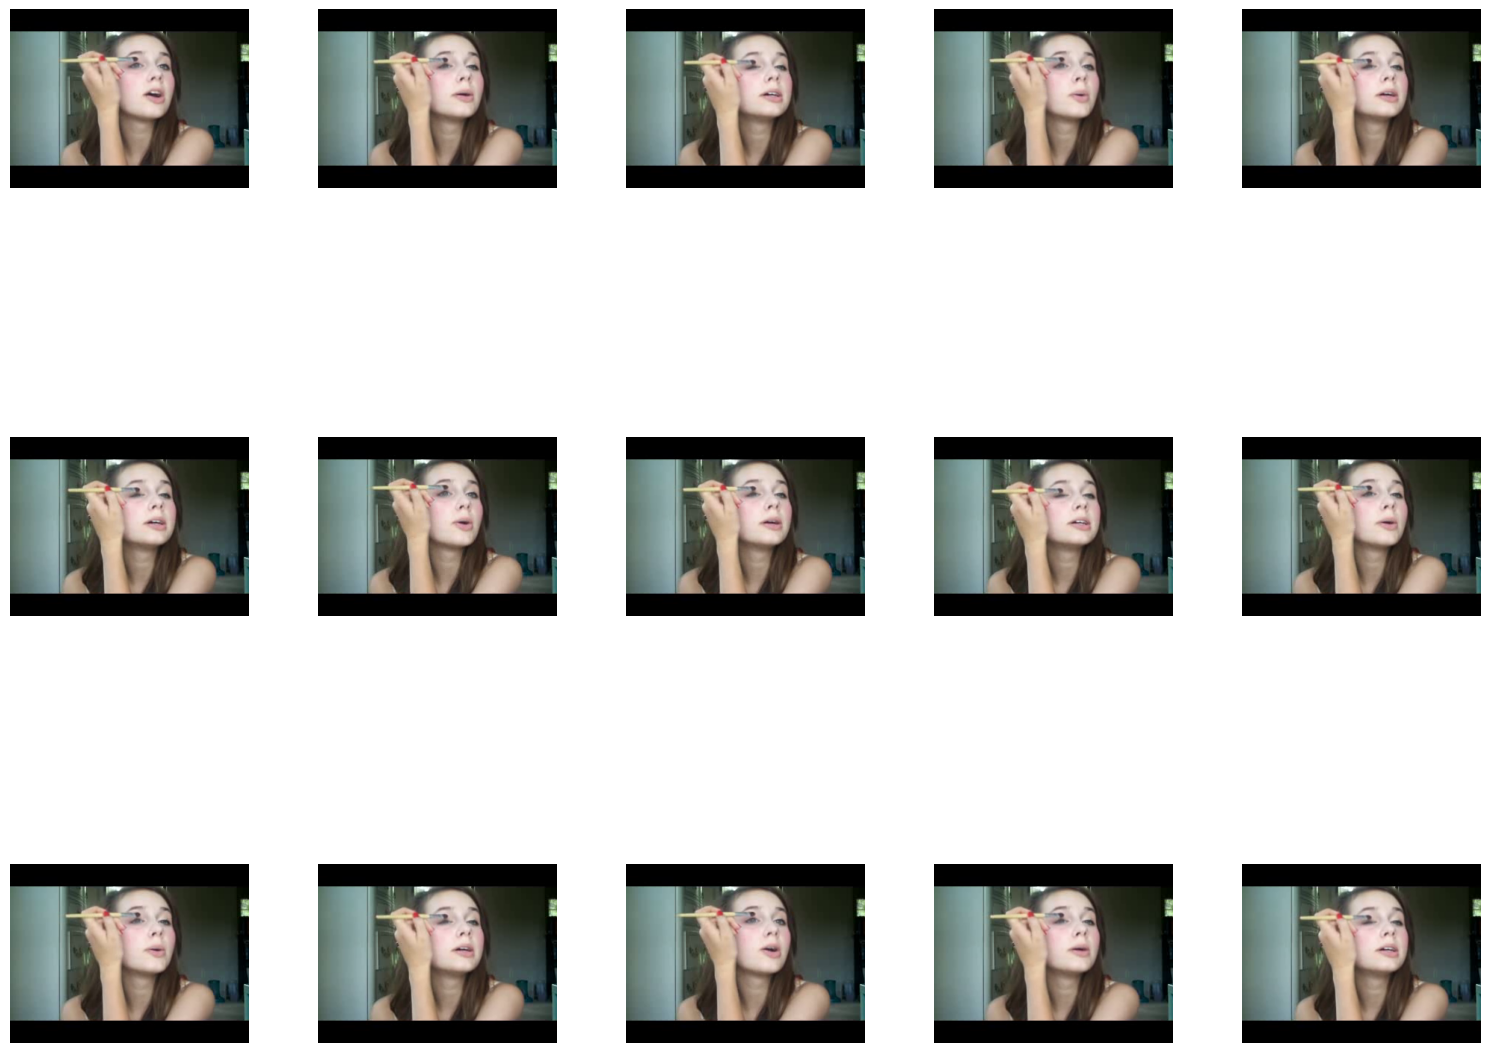

In [5]:
#plt.figure(figsize=(15, 15))
fig, axs = plt.subplots(3, 5, figsize=(15, 15))
for i in range(FRAMES_PER_CLIP):
    axs[i%3, i%5].imshow(train_data[1][0][i])
    axs[i%3, i%5].axis("off")
fig.tight_layout(h_pad=0.1, w_pad=5)

# Разделим датасет, обучим данные

UCF-101 содержит как видео-, так и аудио-дорожки, но они нам не нужны, поэтому напишем функция custom_collate, чтобы отбросить аудиодорожки.

In [6]:
def custom_collate(batch):
    filtered_batch = []
    for video, _, label in batch:
        filtered_batch.append((video, label))
    return torch.utils.data.dataloader.default_collate(filtered_batch)

train_loader, valid_loader - нужны для загрузки данных из датасета.

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=SHUFFLE_DATASET)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=SHUFFLE_DATASET)

Создадим экземпляр модели, определим функцию потерь и оптимизирующий алгоритм.

In [8]:
model_3d = CNNModel()

In [9]:
criterion_3d = torch.nn.CrossEntropyLoss()
optimizer_3d = optim.Adam(model_3d.parameters(), lr=1e-3)

Перенесем модель на GPU.

In [10]:
model_3d = model_3d.to(DEVICE)

Обучим модель и начертим кривую обучения.

In [11]:
loss_3d = train_3d(model=model_3d, n_epochs=10, optimizer=optimizer_3d, criterion=criterion_3d, train_loader=train_loader, valid_loader=valid_loader, device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

D:\unik\nn_vk\action-recognition\models.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1, Training loss 4.626884040832519, Training F1 9.31857866817154e-05
Epoch 1, Training loss 4.621312236785888, Training F1 0.00019672552298288792


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2, Training loss 4.623240432739258, Training F1 0.00016307513578794897
Epoch 2, Training loss 4.6226154327392575, Training F1 0.0001747233181959018


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3, Training loss 4.621990432739258, Training F1 0.0001863715733634308
Epoch 3, Training loss 4.618865432739258, Training F1 0.0002446126309223473


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4, Training loss 4.619490432739258, Training F1 0.0002303759683854878
Epoch 4, Training loss 4.618865432739258, Training F1 0.0002433183981338516


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5, Training loss 4.623240432739258, Training F1 0.00016307513578794897
Epoch 5, Training loss 4.625115432739258, Training F1 0.00012813044304493815


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6, Training loss 4.626990432739258, Training F1 9.31857866817154e-05
Epoch 6, Training loss 4.625115432739258, Training F1 0.00012813044304493815


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7, Training loss 4.6244904327392575, Training F1 0.0001397786836605519
Epoch 7, Training loss 4.625740432739258, Training F1 0.00011648223153315485


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8, Training loss 4.625740432739258, Training F1 0.00011648223880911246
Epoch 8, Training loss 4.6244904327392575, Training F1 0.00013848442176822573


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9, Training loss 4.6244904327392575, Training F1 0.0001397786836605519
Epoch 9, Training loss 4.621365432739258, Training F1 0.00019672552298288792


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10, Training loss 4.620740432739257, Training F1 0.00020966801093891263
Epoch 10, Training loss 4.620740432739257, Training F1 0.00020966798183508217


Text(0, 0.5, 'Loss')

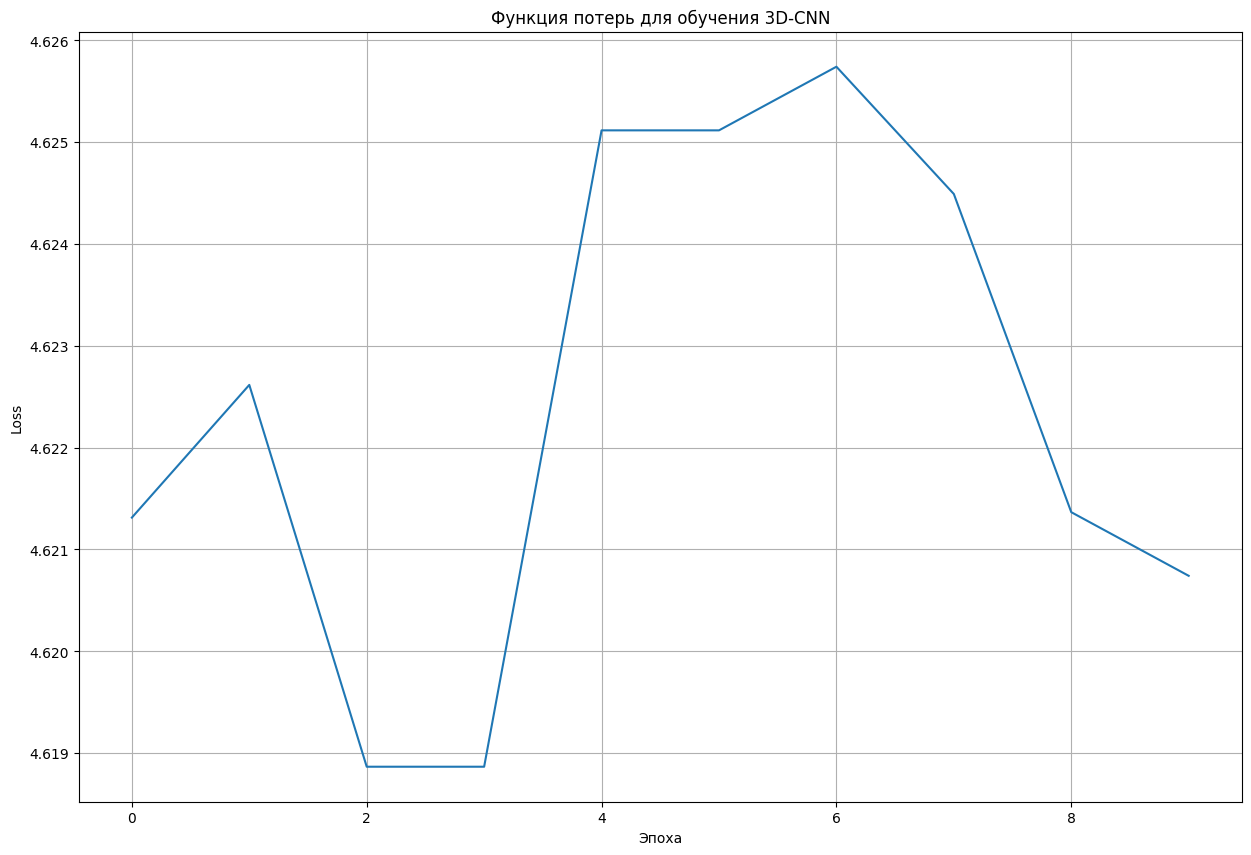

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(loss_3d)
plt.grid('minor')
plt.title('Функция потерь для обучения 3D-CNN')
plt.xlabel('Эпоха')
plt.ylabel('Loss')

Создадим и обучим вторую модель, начертим кривую обучения

In [14]:
#Здесь используем готовый ResNet18.
model_2d = resnet18(pretrained=False)
model_2d.fc = nn.Linear(512, 101)
model_2d

D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D;\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
criterion_2d = torch.nn.CrossEntropyLoss()
optimizer_2d = optim.Adam(model_2d.parameters(), lr=1e-3)

In [16]:
model_2d = model_2d.to(DEVICE)

In [17]:
loss_2d = train_2d(model=model_2d, n_epochs=10, optimizer=optimizer_2d, criterion=criterion_2d, train_loader=train_loader, valid_loader=valid_loader, device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Training loss 4.8736004066467284, Training F1 0.0031958192121237516
Epoch 1, Training loss 4.668442087173462, Training F1 0.004216564353555441


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2, Training loss 4.256761093139648, Training F1 0.006942950654774904
Epoch 2, Training loss 4.210922245979309, Training F1 0.007920321077108383


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3, Training loss 4.111238498687744, Training F1 0.009308344684541225
Epoch 3, Training loss 4.093107380867004, Training F1 0.008923385292291641


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4, Training loss 3.9424085521698, Training F1 0.014118809252977371
Epoch 4, Training loss 3.9464354276657105, Training F1 0.013309291563928127


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5, Training loss 3.828104114532471, Training F1 0.014514850452542305
Epoch 5, Training loss 3.760305049419403, Training F1 0.01592409424483776


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6, Training loss 3.682028498649597, Training F1 0.018957097083330154
Epoch 6, Training loss 3.649669508934021, Training F1 0.019217828288674355


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7, Training loss 3.5164202308654784, Training F1 0.023320132866501808
Epoch 7, Training loss 3.5146322870254516, Training F1 0.022940602153539658


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8, Training loss 3.436174192428589, Training F1 0.024250822141766548
Epoch 8, Training loss 3.4065240097045897, Training F1 0.02397029846906662


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9, Training loss 3.3076022911071776, Training F1 0.02593965083360672
Epoch 9, Training loss 3.3107964062690733, Training F1 0.02612164244055748


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10, Training loss 3.2198542976379394, Training F1 0.03017161786556244
Epoch 10, Training loss 3.2563126516342162, Training F1 0.029490817338228226


Text(0, 0.5, 'Loss')

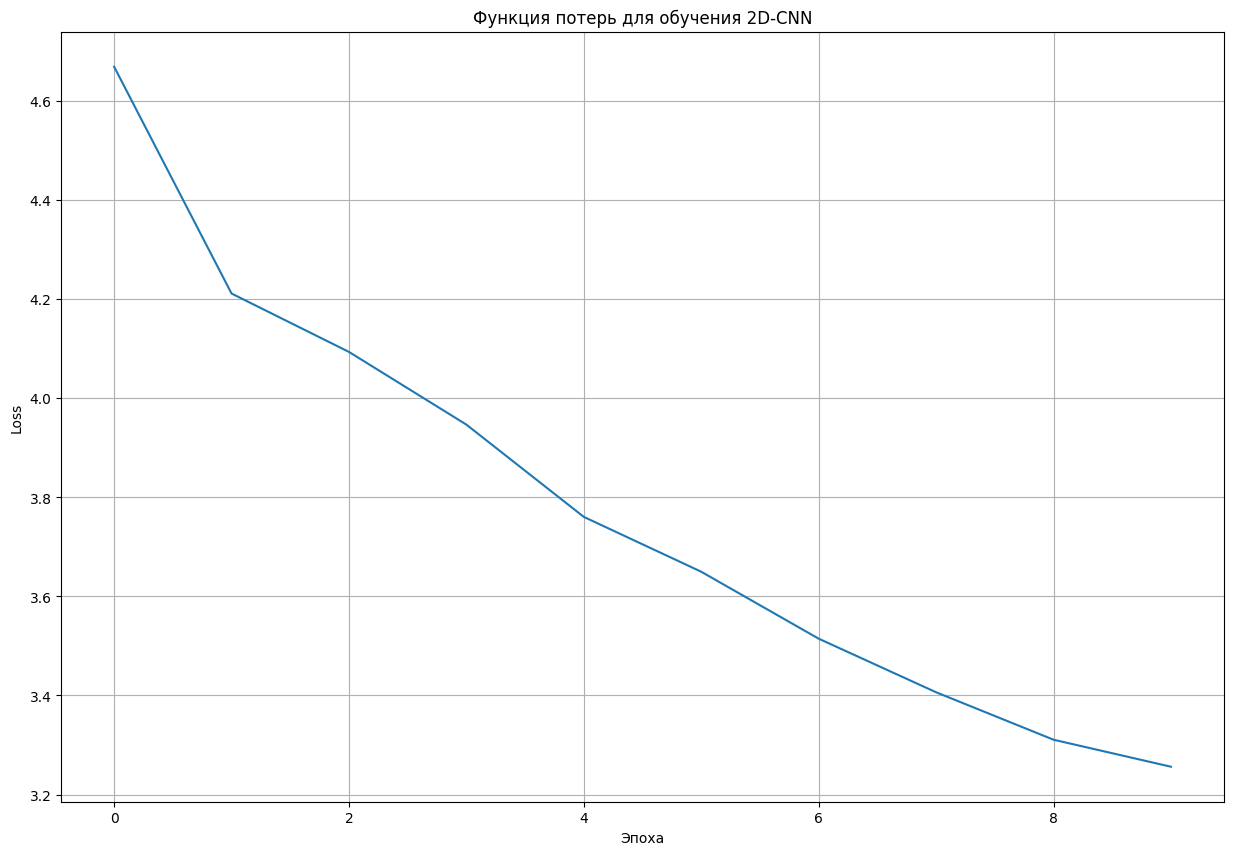

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(loss_2d)
plt.grid('minor')
plt.title('Функция потерь для обучения 2D-CNN')
plt.xlabel('Эпоха')
plt.ylabel('Loss')